In [2]:
import pandas as pd

In [3]:
from google.colab import files
import io
uploaded = files.upload()
data_file = pd.read_csv(io.BytesIO(uploaded["CreditCard_data.csv"]))
data_file.head()

Saving CreditCard_data.csv to CreditCard_data.csv


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
credit_card_data = data_file.copy()

In [6]:
# Handle missing values if any. Here, missing values are filled with the median of each column.
credit_card_data.fillna(credit_card_data.median(), inplace=True)

# Normalize or standardize the data since GMM is sensitive to the scale of data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Assuming 'CUST_ID' is the customer identifier and should be excluded from scaling
features = credit_card_data.drop(columns=['CUST_ID'])
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)


<ipython-input-6-c14cab241cee>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  credit_card_data.fillna(credit_card_data.median(), inplace=True)


In [7]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Use methods like the elbow method, AIC, BIC or silhouette score to choose the number of components
# Placeholder for these methods - detailed code for each method will be provided if needed
n_components = np.arange(1, 21)  # Example range, can be adjusted
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(scaled_features_df)
          for n in n_components]

# Example for BIC
bic = [m.bic(scaled_features_df) for m in models]
aic = [m.aic(scaled_features_df) for m in models]


In [8]:
# Instantiate and fit a Gaussian Mixture Model with the chosen number of components
# Assuming we chose 3 based on the previous step
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(scaled_features_df)

# Predict the cluster labels
cluster_labels = gmm.predict(scaled_features_df)

# Add the cluster labels back to the original dataframe for interpretation
credit_card_data['Cluster'] = cluster_labels


In [9]:
# Calculate silhouette score as an example evaluation metric
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')


Silhouette Score: 0.113


In [10]:
# Analyze the mean values of each cluster
cluster_means = credit_card_data.groupby('Cluster').mean()

# Interpret the clusters
# Placeholder for interpretation - this will require domain knowledge and detailed analysis


<ipython-input-10-60da4426c43c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = credit_card_data.groupby('Cluster').mean()


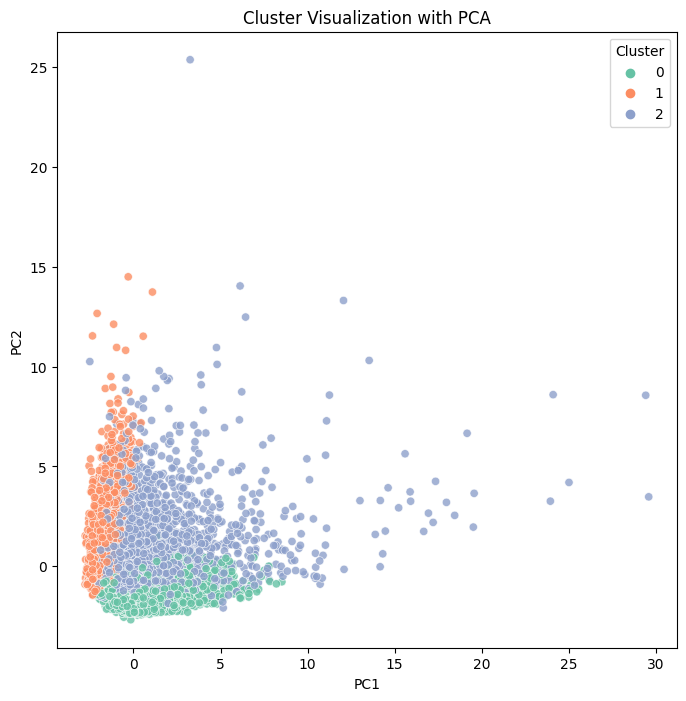

In [11]:
# PCA for dimensionality reduction to visualize clusters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', alpha=0.8)
plt.title('Cluster Visualization with PCA')
plt.show()
